In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# Standard python libraries
import os
import requests

# Essential DS libraries
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, roc_curve, RocCurveDisplay, auc, precision_score, roc_auc_score, accuracy_score, f1_score

import matplotlib.pyplot as plt
import seaborn as sns

# Experiments block
import wandb


pd.set_option('display.max_columns', None)

In [3]:
# Подготовим инфраструктуру для версионирования экспериментов
project_name = "Makarov_mfdp_unit_5"
exp_name = "exp_"
config = []

In [4]:
# Подгрузим датасет с удалёнными коррелирующими и на 90% пустыми признаками
train_corrs_removed = pd.read_csv("features_selected_without_boost_selection.csv")
train_corrs_removed = train_corrs_removed.drop(["Unnamed: 0"], axis=1)

## Эксперимент 0 - бэйзлайн
Снижаем количество колонок с помощью Feature importances. Мы совершенно точно знаем с экспериментов предыдущего урока, что цикличное удаление околонулевых фичей имеет сходимость - на пятую итерацию таких фичей в датасете не будет. В оригинальном подходе использовался первчный feature selection через lightGBM и 4 итерации catboost. Здесь же соберём исключительно catboost.

In [5]:
X = train_corrs_removed.drop(columns=["TARGET"]).set_index("SK_ID_CURR")
y = train_corrs_removed["TARGET"]
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    random_state=42, 
                                                    test_size=0.2)

# Initialize CatBoostClassifier
catboost_model = CatBoostClassifier(
    iterations=100,  # Modify this parameter as needed
    thread_count=8, 
    custom_metric = ['F1:use_weights=true', 
                     'Precision:use_weights=true', 
                     'Recall:use_weights=true', 
                     'Accuracy:use_weights=true', 
                     'NormalizedGini:use_weights=true'],
    eval_metric='AUC',  # Changed to AUC
    auto_class_weights='Balanced' ,
    verbose=100,  # Output the training process every 100 iterations
    random_seed=42
    
)

# Create a pandas dataframe for easier visualization
def create_importance_df(X_train, feature_importances):
    importance_df = pd.DataFrame({
        'Features': X_train.columns,
        'Importance': feature_importances
    })
    
    # Sort the dataframe based on the feature importances
    importance_df = importance_df.sort_values(by='Importance', ascending=False)
    return importance_df

# Get feature importances
def get_feature_importances():
    feature_importances = catboost_model.get_feature_importance()
    importance_df = importance_df_dr

    # Plot the feature importances
    plt.figure(figsize=(12, 8))
    plt.barh(importance_df['Features'], importance_df['Importance'])
    plt.xlabel('Importance')
    plt.ylabel('Features')
    plt.title('Feature Importances')
    plt.gca().invert_yaxis()
    plt.show()

Learning rate set to 0.180666
0:	test: 0.6848299	best: 0.6848299 (0)	total: 151ms	remaining: 15s
99:	test: 0.7071266	best: 0.7078568 (10)	total: 1.81s	remaining: 0us

bestTest = 0.7078567732
bestIteration = 10

Shrink model to first 11 iterations.


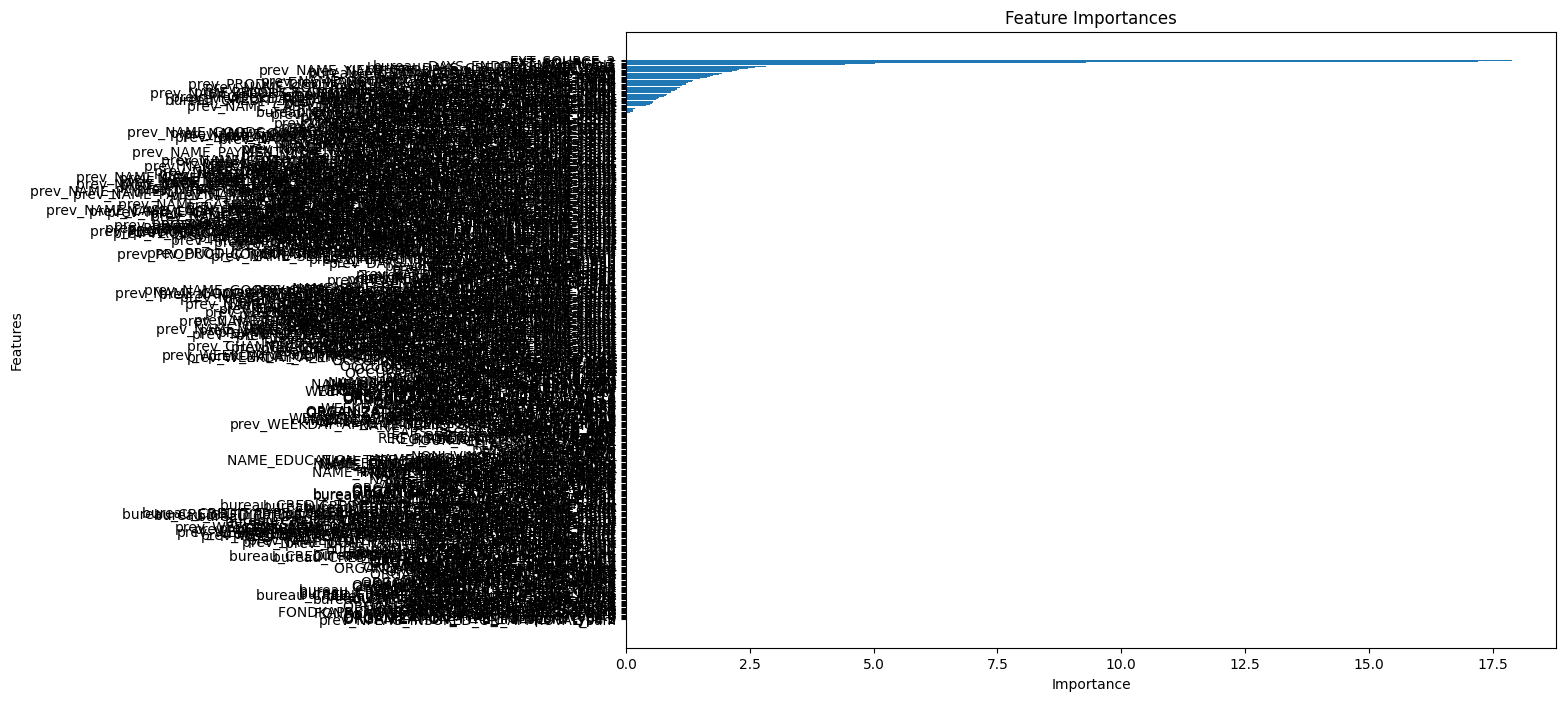

In [6]:
# Установочный запуск + иницииализация параметров
catboost_model.fit(X_train, y_train, eval_set=(X_test, y_test), use_best_model=True)


# Get feature importances
feature_importances = catboost_model.get_feature_importance()

# Create a pandas dataframe for easier visualization
importance_df = pd.DataFrame({
    'Features': X_train.columns,
    'Importance': feature_importances
})

# Sort the dataframe based on the feature importances
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(12, 8))
plt.barh(importance_df['Features'], importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importances')
plt.gca().invert_yaxis()
plt.show()

Learning rate set to 0.180666
0:	test: 0.6522129	best: 0.6522129 (0)	total: 6.64ms	remaining: 657ms
99:	test: 0.7014006	best: 0.7025966 (79)	total: 634ms	remaining: 0us

bestTest = 0.7025965519
bestIteration = 79

Shrink model to first 80 iterations.
Learning rate set to 0.180666
0:	test: 0.6722413	best: 0.6722413 (0)	total: 6.75ms	remaining: 669ms
99:	test: 0.6867132	best: 0.6986019 (13)	total: 624ms	remaining: 0us

bestTest = 0.6986018566
bestIteration = 13

Shrink model to first 14 iterations.
Learning rate set to 0.180666
0:	test: 0.6721568	best: 0.6721568 (0)	total: 9.69ms	remaining: 959ms
99:	test: 0.6904887	best: 0.7047847 (39)	total: 618ms	remaining: 0us

bestTest = 0.7047847393
bestIteration = 39

Shrink model to first 40 iterations.


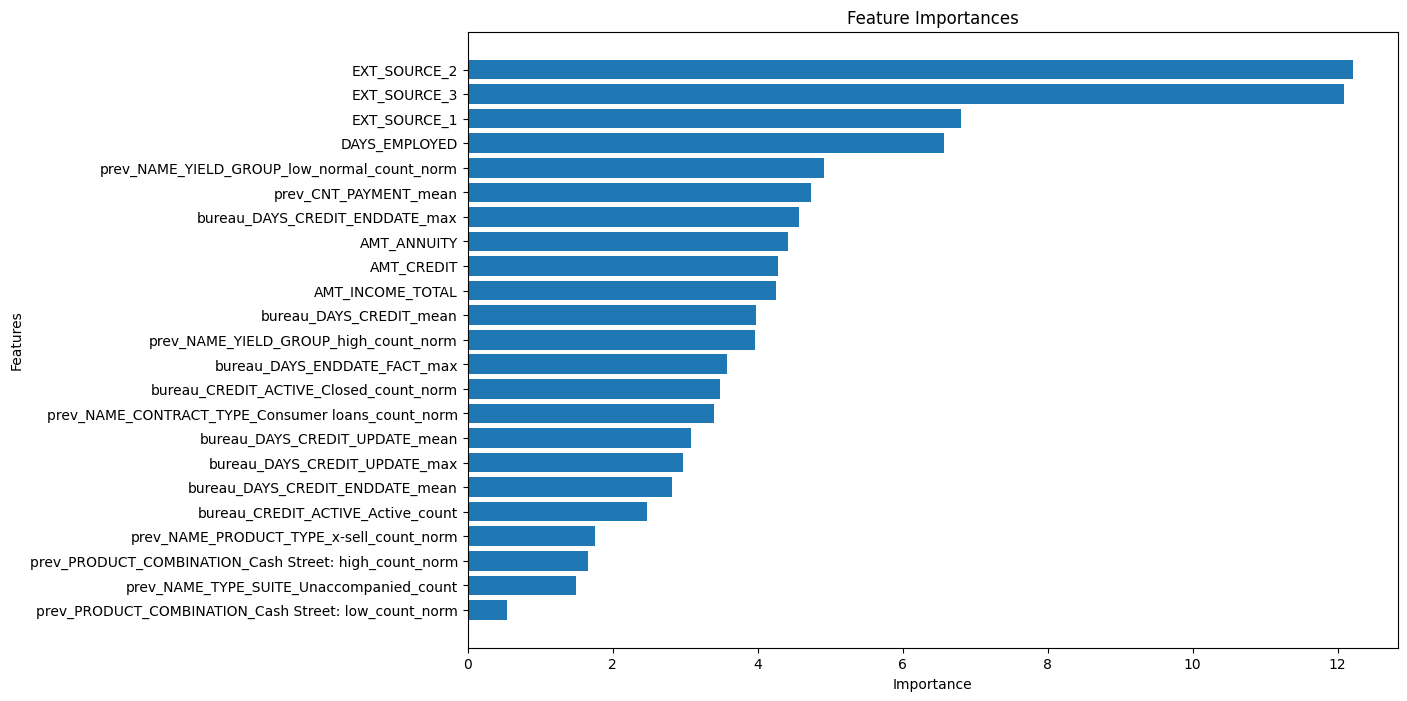

{'learn': {'Accuracy:use_weights=true': 0.8769252153689019,
  'Logloss': 0.3667054662256055,
  'Precision:use_weights=true': 0.8438778383407384,
  'F1:use_weights=true': 0.8825679482066477,
  'Recall:use_weights=true': 0.9249762583095916},
 'validation': {'NormalizedGini:use_weights=true': 0.4095694785871393,
  'Accuracy:use_weights=true': 0.6539556105445353,
  'Logloss': 0.631467878507873,
  'Precision:use_weights=true': 0.7051272132433817,
  'F1:use_weights=true': 0.6581620266587699,
  'Recall:use_weights=true': 0.683206106870229,
  'AUC': 0.7047847392935697}}

In [7]:
importance_df_dr = importance_df
features_to_drop = importance_df_dr[importance_df_dr["Importance"] <= 0.5]["Features"]
train_dropped = train_corrs_removed.drop(columns=features_to_drop)



while len(importance_df_dr[importance_df_dr["Importance"] <= 0.5]) > 0:
   
    X_dr = train_dropped.drop(columns=["TARGET"]).set_index("SK_ID_CURR")
    y_dr = train_dropped["TARGET"]
    
    X_train_dr, X_test_dr, y_train_dr, y_test_dr = train_test_split(X_dr, y_dr, 
                                                        random_state=42, 
                                                        test_size=0.2)
    
    # Fit model
    catboost_model.fit(X_train_dr, y_train_dr, eval_set=(X_test_dr, y_test_dr), use_best_model=True)
    feature_importances_dr = catboost_model.get_feature_importance()
    importance_df_dr = create_importance_df(X_train_dr, feature_importances_dr)
    features_to_drop = importance_df_dr[importance_df_dr["Importance"] <= 0.5]["Features"]
    train_dropped = train_dropped.drop(columns=features_to_drop)
get_feature_importances()
catboost_model.get_best_score()

In [8]:
# Пытаемся понять значение 'Precision:use_weights=true': 0.7051272132433817
print(classification_report(y_test, catboost_model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.97      0.73      0.83      4720
           1       0.10      0.55      0.17       262

    accuracy                           0.72      4982
   macro avg       0.53      0.64      0.50      4982
weighted avg       0.92      0.72      0.79      4982



In [9]:
y_pred = catboost_model.predict_proba(X_test)[:, 1]

wandb.init(
        project=project_name, name=exp_name+"0"+"_baseline"
    )  # Инициализация эксперимента, project - название проекта
wandb.log(
    {
        "accuracy_score": accuracy_score(y_true=y_test, y_pred=catboost_model.predict(X_test)),
        "f1_score_weighted": f1_score(y_true=y_test, y_pred=catboost_model.predict(X_test), average="weighted"),
        "precision_weighted": precision_score(y_true=y_test, y_pred=catboost_model.predict(X_test), average="weighted"),
        "roc_auc_score": roc_auc_score(y_true=y_test, y_score=y_pred, average="weighted"),
        "gini": 2 * roc_auc_score(y_true=y_test, y_score=y_pred, average="weighted") - 1
    }
)
wandb.sklearn.plot_roc(y_true = y_test, y_probas = catboost_model.predict_proba(X_test))
wandb.sklearn.plot_class_proportions(y_train, y_test)
wandb.finish()

wandb: Currently logged in as: qeshtir (qesh-squad). Use `wandb login --relogin` to force relogin


wandb: WARNING wandb.plots.* functions are deprecated and will be removed in a future release. Please use wandb.plot.* instead.


accuracy_score,▁
f1_score_weighted,▁
gini,▁
precision_weighted,▁
roc_auc_score,▁
accuracy_score,0.71618
f1_score_weighted,0.79418
gini,0.40957
precision_weighted,0.92139
roc_auc_score,0.70478


In [11]:
best_features = importance_df_dr["Features"]
best_features.to_csv("0_best_features_names_baseline.csv", index=False)
train_dropped.to_csv("0_best_features_baseline.csv", index=False)